### This notebook studies the distribution of SWR ripple amplitude.
#### Goals:
##### 1. Are the amplitude of envelope of ripple band on each channel normally distributed? While the consensus trace is Chi-Square. At n = what are we ok to use Normal distribution approximation? How do distribution change with number of electrodes?
##### 2. How do the distribution of amplitude vary between rats?

April 30 - May 7, 2024
Shijie Gu

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
import pynwb
import xarray as xr

from spyglass.common.common_interval import _intersection
from spyglass.common import (IntervalPositionInfo, IntervalPositionInfoSelection, IntervalList, 
                             ElectrodeGroup, LFP, BrainRegion, LFPBand, Electrode)
from ripple_detection import Kay_ripple_detector
from ripple_detection.core import (gaussian_smooth,
                                   get_envelope,
                                   get_multiunit_population_firing_rate,
                                   threshold_by_zscore,
                                   segment_boolean_series,
                                   exclude_close_events,
                                   exclude_movement,
                                   extend_threshold_to_mean)
from ripple_detection.detectors import Kay_ripple_detector,multiunit_HSE_detector
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,)

from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes
from spyglass.shijiegu.helpers import interval_union,interpolate_to_new_time
from spyglass.shijiegu.load import load_LFP
from spyglass.shijiegu.ripple_detection import (loadRippleLFP,get_Kay_ripple_consensus_trace,plot_ripple,threshold_by_zscore_Gu,Gu_ripple_detector,)
from spyglass.common.common_position import IntervalLinearizedPosition

[2024-05-02 09:48:20,572][INFO]: Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
[2024-05-02 09:48:20,614][INFO]: Connected shijiegu@lmf-db.cin.ucsf.edu:3306


In [6]:
def getRippleEnvelope(nwb_file_name,interval_list_name,pos_interval_list_name):
    """
    returns:
    filtered_lfps: (session length) x (number of channels)
    CA1TetrodeInd: column index of filtered_lfps that correspond to a CA1 tetrode. One for each electrode.
    CCTetrodeInd: column index of filtered_lfps that correspond to a reference tetrodes.
    """
    nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

    position_valid_times = (IntervalList & {'nwb_file_name': nwb_copy_file_name,
                                        'interval_list_name': pos_interval_list_name}).fetch1('valid_times')

    # Ripple-band LFP
    ripple_data, ripple_timestamps, electrodes = loadRippleLFP(nwb_copy_file_name,interval_list_name,
                                                         position_valid_times,
                                                         'filtered data');
    electrodes.index = np.arange(len(electrodes))

    # find tetrodes with signal
    groups_with_cell=(SpikeSortingRecordingSelection & {
        'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id')
    groups_with_cell
    groups_with_cell=np.setdiff1d(groups_with_cell,[100,101])

    ## get index for each electrode with cell, only choose one channel
    CA1TetrodeInd = []
    for e in groups_with_cell:
        CA1TetrodeInd.append(electrodes[electrodes['group_name']==str(e)].index[0])
    
    ## get reference electrode index
    CCTetrodeInd = []
    LFPTetID = np.array([int(a) for a in np.unique(electrodes.group_name)])
    CA1TetrodeReferenceTetID = np.setdiff1d(LFPTetID,groups_with_cell)
    
    for e in np.unique(np.array(CA1TetrodeReferenceTetID)):
        CCTetrodeInd.append(electrodes[electrodes['group_name']==str(e)].index[0])

    ### get envelope
    not_null = np.all(pd.notnull(ripple_data), axis=1)
    
    filtered_lfps, time = (
            ripple_data[not_null], ripple_timestamps[not_null])
    
    filtered_lfps = get_envelope(filtered_lfps)

    return filtered_lfps, CA1TetrodeInd, CCTetrodeInd

In [ ]:
filtered_lfps = {}
CA1TetrodeInd = {}
CCTetrodeInd = {}

nwb_file_name = 'eliot20221020.nwb'
pos_interval_list_name = 'pos 1 valid times'
interval_list_name='02_Seq2Session1'

filtered_lfps['eliot'], CA1TetrodeInd['eliot'], CCTetrodeInd['eliot'] = getRippleEnvelope(
    nwb_file_name,interval_list_name,pos_interval_list_name)

nwb_file_name = 'molly20220416.nwb'
pos_interval_list_name = 'pos 1 valid times'
interval_list_name='02_Seq2Session1'

filtered_lfps['molly'], CA1TetrodeInd['molly'], CCTetrodeInd['molly'] = getRippleEnvelope(
    nwb_file_name,interval_list_name,pos_interval_list_name)

In [13]:
print(len(CA1TetrodeInd['molly']),len(CA1TetrodeInd['eliot']))

28 16


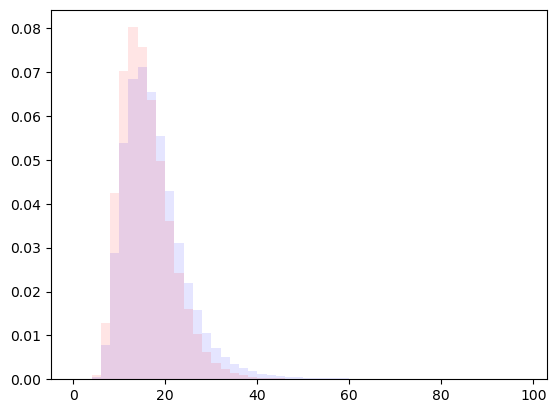

In [12]:
summed_lfp_molly = np.mean(filtered_lfps['molly'][:,CA1TetrodeInd['molly']],axis=1)
summed_lfp_eliot = np.mean(filtered_lfps['eliot'][:,CA1TetrodeInd['eliot']],axis=1)
plt.hist(summed_lfp_molly,bins=np.arange(0,100,2),color = 'b',alpha = 0.1,density=True);
plt.hist(summed_lfp_eliot,bins=np.arange(0,100,2),color = 'r',alpha = 0.1,density=True);

#### What about squared sum (consensus trace)

Text(0.5, 1.0, 'consensus trace value histogram (a session)')

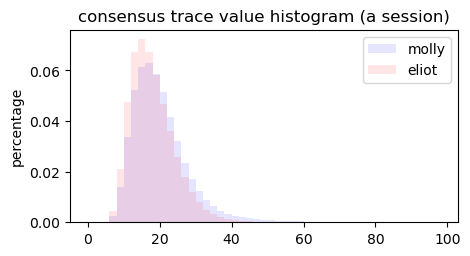

In [41]:
plt.figure(figsize = (5,2.5))
summed_lfp = {}
summed_lfp['molly'] = np.sqrt(np.mean(np.square(filtered_lfps['molly'])[:,CA1TetrodeInd['molly']],axis=1))
summed_lfp['eliot'] = np.sqrt(np.mean(np.square(filtered_lfps['eliot'])[:,CA1TetrodeInd['eliot']],axis=1))
plt.hist(summed_lfp['molly'],bins=np.arange(0,100,2),color = 'b',alpha = 0.1,density=True,label='molly');
plt.hist(summed_lfp['eliot'],bins=np.arange(0,100,2),color = 'r',alpha = 0.1,density=True,label='eliot');
plt.legend()
plt.ylabel('percentage')
plt.title('consensus trace value histogram (a session)')

In [44]:
threshold1 = np.mean(summed_lfp['molly']) + np.std(summed_lfp['molly']) * 2
threshold2 = np.quantile(summed_lfp['molly'],1-0.025)
print("Number of timestamps of Ripple LFP envelop over 2 SD is " + str(np.sum(summed_lfp_molly > (threshold1))))
print("Number of timestamps of Ripple LFP envelop over 0.975 quantile is " + str(np.sum(summed_lfp_molly > (threshold2))))

Number of timestamps of Ripple LFP envelop over 2 SD is 18704
Number of timestamps of Ripple LFP envelop over 0.975 quantile is 15656


In [45]:
threshold1 = np.mean(summed_lfp['eliot']) + np.std(summed_lfp['eliot']) * 2
threshold2 = np.quantile(summed_lfp['eliot'],1-0.025)
print("Number of timestamps of Ripple LFP envelop over 2 SD is " + str(np.sum(summed_lfp_molly > (threshold1))))
print("Number of timestamps of Ripple LFP envelop over 0.975 quantile is " + str(np.sum(summed_lfp_molly > (threshold2))))

Number of timestamps of Ripple LFP envelop over 2 SD is 40663
Number of timestamps of Ripple LFP envelop over 0.975 quantile is 39560


#### Answers: Despite almost half the difference in the number of electrodes, eliot and molly's ripple band LFP envelope distribution are both quite skewed. At the same time though, using 2SD (implicit normal distribution approximation) is able to find us approximately the top 2.5% of events.

Text(0.5, 1.0, 'Individual tetrode ripple band envelope is Log-normal looking')

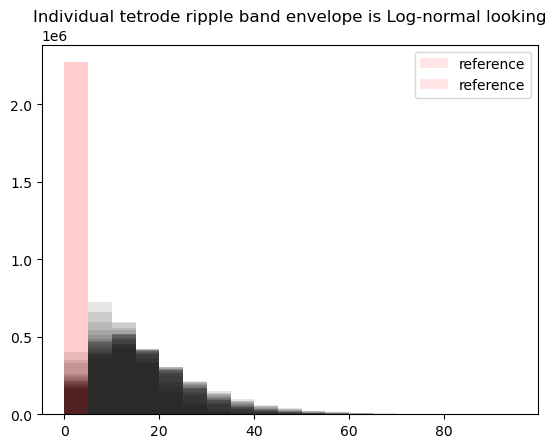

In [159]:
### histogram of ripple envelopre amplitude
for i in CA1TetrodeInd:
    plt.hist(filtered_lfps[:,i],bins=np.arange(0,100,5),color = 'k',alpha = 0.1);
    #plt.hist(filtered_lfps[:,4],bins=np.arange(0,100,5));
for i in CCTetrodeInd:
    plt.hist(filtered_lfps[:,i],bins=np.arange(0,100,5),color = 'r',alpha = 0.1,
             label = 'reference');
plt.legend()
plt.title('Individual tetrode ripple band envelope is Log-normal looking')